# This notebook has an [interactive version](https://githubtocolab.com/SWIFTSIM/swiftgalaxy/blob/main/examples/SWIFTGalaxy_demo.ipynb)

# Install dependencies & setup

❗You may need to restart the runtime or kernel after installation.❗

In [1]:
try:
    import swiftgalaxy
    import SOAP
except ImportError:
    !pip install swiftgalaxy@git+https://github.com/SWIFTSIM/swiftgalaxy.git
    !pip install SOAP@git+https://github.com/SWIFTSIM/SOAP.git@soap_runtime

Ensure that plots appear:

In [2]:
%matplotlib inline

# Create a simple toy-model snapshot and halo finder output

`swiftgalaxy` comes with utilities to create some simple example data on the fly that we can use to give us some lightweight data to experiment with. These are accessed via a helper class `demo_data.generated_examples`. The example data files are automatically created in a directory `demo_data` when the attributes of `generated_examples` are accessed, and the attributes resolve to the file paths of the example files. The upshot is that we can pass the helper class attributes in places where `swiftgalaxy` expects file names and the files will be automatically created and read in. (There are also some more "realistic" example data files from an actual simulation run that can be downloaded with the `demo_data.web_examples` helper class.)

The sample snapshot is a periodic simulation volume with a uniform background density of dark matter and gas. The box has a side length of 10 Mpc. At coordinates (2, 2, 2) Mpc is a very crude "galaxy" composed of:
 - a gas disc 10 kpc in radius and 2 kpc thick with 1/R surface density scaling and vertically uniform density
 - a spherical dark matter halo 100 kpc in radius with 1/r^2 density scaling
 - a stellar disc 5 kpc in radius and 1 kpc thick with 1/R surface density scaling and vertically uniform density
 - a central black hole

There is a second similar galaxy at coordinates (8, 8, 8) Mpc.

In [3]:
from swiftgalaxy.demo_data import generated_examples

# Start tutorial

## Initial setup

In this section we import required modules, and make a quick visualisation (using `swiftsimio`) of the snapshot where our galaxy lives.

First let's import the two basic pieces needed to set up a `SWIFTGalaxy`: the `SWIFTGalaxy` class itself, and a halo finder class from `swiftgalaxy`, in this case `SOAP`.

In [4]:
from swiftgalaxy import SWIFTGalaxy, SOAP

We'll also import some `swiftsimio` and `matplotlib` things for visualisation purposes.

In [5]:
import unyt as u
from swiftsimio import SWIFTDataset
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation import generate_smoothing_lengths
import matplotlib.pyplot as plt
import matplotlib.colors

Let's load up our snapshot file in a `SWIFTDataset` (from swiftsimio) so that we can have a quick look at the contents.

In [6]:
sd = SWIFTDataset(generated_examples.snapshot)

Before visualising the simulation, we need to initialise some smoothing lengths for the particles (this is taken from the `swiftsimio` visualisation documentation). The snapshot file contains "smoothing lengths", but these are just the mean interparticle spacing, which is inappropriate for a non-uniform particle distribution.

In [7]:
for ptype in "gas", "dark_matter", "stars":
    getattr(sd, ptype).smoothing_length = generate_smoothing_lengths(
        getattr(sd, ptype).coordinates,
        sd.metadata.boxsize,
        kernel_gamma=1.8,
        neighbours=57,
        speedup_fac=2,
        dimension=3,
    )

We can use the `swiftsimio` visualisation tools to make `x-y`, `y-z` and `x-z` projections of the snapshot, and plot them.

Text(0.5, 0.98, 'gas density')

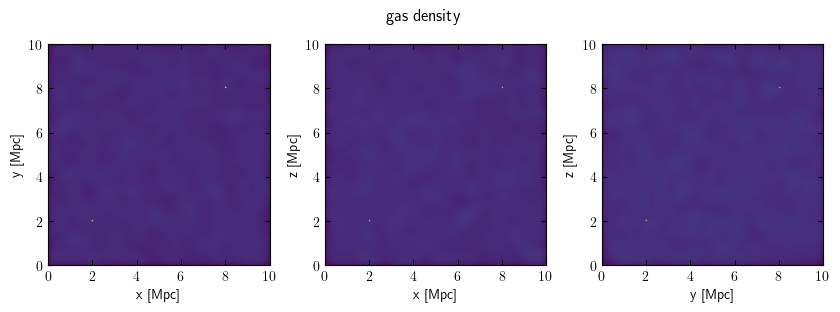

In [8]:
boxsize = sd.metadata.boxsize
img_extent = [0, boxsize[0], 0, boxsize[0]]
box_centre = boxsize / 2

mass_map_xy = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
    periodic=False,
    rotation_matrix=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    rotation_center=box_centre,
)
mass_map_xz = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
    periodic=False,  # required to use rotation
    rotation_matrix=[[0, 0, 1], [0, 1, 0], [-1, 0, 0]],
    rotation_center=box_centre,
)
mass_map_yz = project_gas(
    sd,
    resolution=256,
    project="masses",
    parallel=True,
    periodic=False,  # required to use rotation
    rotation_matrix=[[1, 0, 0], [0, 0, 1], [0, -1, 0]],
    rotation_center=box_centre,
)

fig = plt.figure(1, figsize=(10, 3))
sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
sp1.imshow(
    matplotlib.colors.LogNorm()(mass_map_xy.to_physical_value(u.solMass / u.kpc**2).T),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp1.set_xlabel(f"x [{boxsize.units}]")
sp1.set_ylabel(f"y [{boxsize.units}]")
sp2.imshow(
    matplotlib.colors.LogNorm()(mass_map_xz.to_physical_value(u.solMass / u.kpc**2).T),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp2.set_xlabel(f"x [{boxsize.units}]")
sp2.set_ylabel(f"z [{boxsize.units}]")
sp3.imshow(
    matplotlib.colors.LogNorm()(mass_map_yz.to_physical_value(u.solMass / u.kpc**2).T),
    cmap="viridis",
    extent=img_extent,
    origin="lower",
)
sp3.set_xlabel(f"y [{boxsize.units}]")
sp3.set_ylabel(f"z [{boxsize.units}]")
fig.subplots_adjust(wspace=0.25)
fig.suptitle("gas density")

We can just barely make out two dots at (2, 2, 2) Mpc and (8, 8, 8) Mpc in the figure: the two galaxies in the snapshot.

Let's also define a function accepting a `SWIFTGalaxy` that we can use below to quickly plot a visualisation of the galaxy.

In [9]:
from swiftsimio import cosmo_array, cosmo_quantity


def myvis(sg, figure=1):
    disc_radius = cosmo_quantity(
        15.0, u.kpc, comoving=False, scale_factor=sg.metadata.a, scale_exponent=1.0
    )
    disc_region = cosmo_array([-disc_radius, disc_radius, -disc_radius, disc_radius])
    halo_radius = cosmo_quantity(
        200.0, u.kpc, comoving=False, scale_factor=sg.metadata.a, scale_exponent=1.0
    )
    halo_region = cosmo_array([-halo_radius, halo_radius, -halo_radius, halo_radius])
    gas_map = project_gas(
        sg,
        resolution=256,
        project="masses",
        periodic=False,  # always recommended for swiftgalaxy
        parallel=True,
        region=disc_region,
    )
    dm_map = project_pixel_grid(
        data=sg.dark_matter,
        resolution=256,
        project="masses",
        periodic=False,  # always recommended for swiftgalaxy
        parallel=True,
        region=halo_region,
    )
    star_map = project_pixel_grid(
        data=sg.stars,
        resolution=256,
        project="masses",
        periodic=False,  # always recommended for swiftgalaxy
        parallel=True,
        region=disc_region,
    )

    fig = plt.figure(figure, figsize=(10, 3))
    sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
    sp1.imshow(
        matplotlib.colors.LogNorm()(gas_map.to_physical_value(u.solMass / u.kpc**2).T),
        cmap="viridis",
        extent=disc_region,
        origin="lower",
    )
    sp1.set_xlabel(f"x' [{disc_radius.units}]")
    sp1.set_ylabel(f"y' [{disc_radius.units}]")
    sp1.text(0.9, 0.9, "gas", ha="right", va="top", transform=sp1.transAxes)
    sp2.imshow(
        matplotlib.colors.LogNorm()(dm_map.to_physical_value(u.solMass / u.kpc**2).T),
        cmap="inferno",
        extent=halo_region,
        origin="lower",
    )
    sp2.plot(
        [-disc_radius, -disc_radius, disc_radius, disc_radius, -disc_radius],
        [-disc_radius, disc_radius, disc_radius, -disc_radius, -disc_radius],
        "-k",
    )
    sp2.set_xlabel(f"x' [{halo_radius.units}]")
    sp2.set_ylabel(f"y' [{halo_radius.units}]")
    sp2.text(0.9, 0.9, "DM", ha="right", va="top", transform=sp2.transAxes)
    sp3.imshow(
        matplotlib.colors.LogNorm()(star_map.to_physical_value(u.solMass / u.kpc**2).T),
        cmap="magma",
        extent=disc_region,
        origin="lower",
    )
    sp3.set_xlabel(f"x' [{disc_radius.units}]")
    sp3.set_ylabel(f"y' [{disc_radius.units}]")
    sp3.text(0.9, 0.9, "stars", ha="right", va="top", transform=sp3.transAxes)
    fig.subplots_adjust(wspace=0.4)

## `SWIFTGalaxy` creation

Creating a `SWIFTGalaxy` is simple: we just provide the snapshot filename (here using the 'virtual snapshot' including group membership information that `SOAP` expects to find), and an initialised halo finder class. In this case, `SOAP` simply needs to know the location of the output files to read, and the position of the galaxy we're interested in within the catalogue.

In [10]:
sg = SWIFTGalaxy(
    generated_examples.virtual_snapshot, SOAP(generated_examples.soap, soap_index=0)
)

Before visualising the galaxy, we again need to initialise some smoothing lengths for the particles.

In [11]:
for ptype in "gas", "dark_matter", "stars":
    getattr(sg, ptype).smoothing_length = generate_smoothing_lengths(
        getattr(sg, ptype).coordinates + sg.centre,
        sg.metadata.boxsize,
        kernel_gamma=1.8,
        neighbours=57,
        speedup_fac=2,
        dimension=3,
    )

Now we can run our visualisation function to have a look at the galaxy:

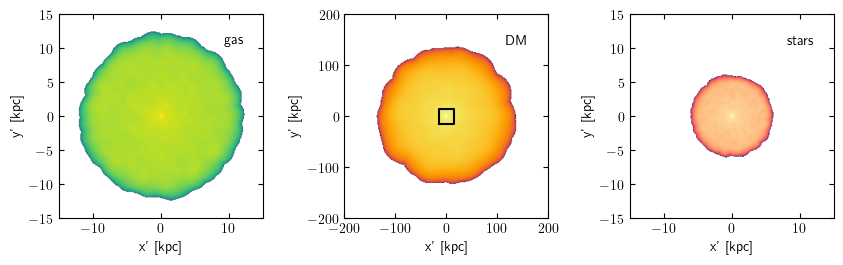

In [12]:
myvis(sg, figure=2)

## Overview of features

### `SWIFTDataset` features

`SWIFTGalaxy` is built upon `swiftsimio` and takes advantage of all the features of the `SWIFTDataset` class, notably "lazy loading" of particle data. A `SWIFTGalaxy` inherits from the `SWIFTDataset` class, and should therefore be accepted by functions expecting a `SWIFTDataset`.

### Automatic recentering

When the `SWIFTGalaxy` is created, the coordinates are automatically centred on the position and velocity (according to the halo finder) of the galaxy of interest. In case there are multiple centres defined, as is the case with `SOAP` (minimum potential, centre of mass, etc.), which one to use is configurable. The automatic recentering can also be disabled entirely, or the centre of another `SWIFTGalaxy` can be used (can be useful e.g. for putting a satellite in the coordinate frame of its central).

### Rotation & other coordinate transformations

The particles in a `SWIFTGalaxy` always occupy a common coordinate frame, such that e.g. all particles rotate together. Rotations, translations (in position) and boosts (translations in velocity) are all supported. As an example, we can rotate our galaxy. To specify a rotation, the [`scipy.spatial.transform.Rotation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) class is used. This accepts rotation matrices, Euler angles, and more.

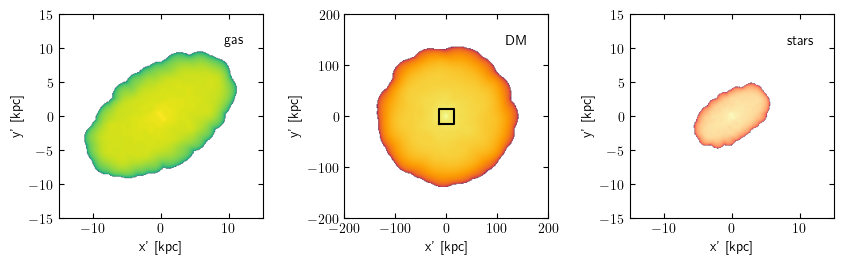

In [13]:
from scipy.spatial.transform import Rotation

sg.rotate(Rotation.from_euler("xy", [60, 30], degrees=True))
myvis(sg, figure=3)

Let's reverse the rotation before continuing with the examples.

In [14]:
sg.rotate(Rotation.from_euler("yx", [-30, -60], degrees=True))

### Additional coordinates

When working with a galaxy it is often convenient to work in spherical or cylindircal coordinates. These are built into a `SWIFTGalaxy` and are evaluated lazily as and when needed. Their consistency when the coordinate frame is transformed is also ensured. As an illustrative example, we can plot the azimuthal velocity against the radial velocity - the figure in which the Gaia-Enceladus (or "sausage") structure in the Milky Way was identified. Of course our crude model galaxy won't have any such interesting structure - indeed the disc isn't even actually rotating!

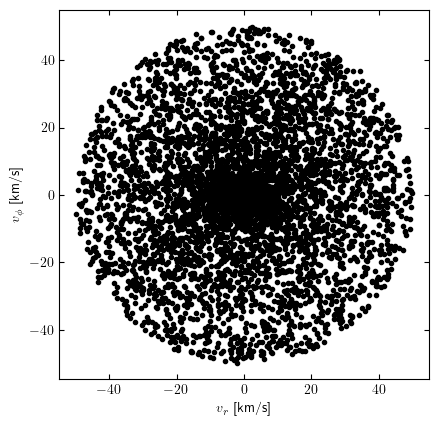

In [15]:
plt.plot(
    sg.stars.spherical_velocities.r.to_physical_value(u.km / u.s),
    sg.stars.spherical_velocities.phi.to_physical_value(u.km / u.s),
    ".k",
    rasterized=True,
)
plt.xlabel(r"$v_r$ [km/s]")
plt.ylabel(r"$v_\phi$ [km/s]")
plt.gca().set_aspect("equal")

### Particle masking

`SWIFTGalaxy` enables selecting subsets of particles in intuitive, syntactically simply ways (beyond what's supported by `swiftsimio`, actually). As an example, we can chop a hole out of the centre of the stellar and gas discs:

In [16]:
from swiftgalaxy import MaskCollection

sg.mask_particles(
    MaskCollection(
        gas=sg.gas.cylindrical_coordinates.R
        > cosmo_quantity(
            2.0, u.kpc, comoving=True, scale_factor=sg.metadata.a, scale_exponent=1.0
        ),
        stars=sg.stars.cylindrical_coordinates.R
        > cosmo_quantity(
            2.0, u.kpc, comoving=True, scale_factor=sg.metadata.a, scale_exponent=1.0
        ),
    )
)
myvis(sg, figure=4)

coordinates (5000, 3) (5000,)
group_nr_bound (16384,) (5000,)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 16384 but size of corresponding boolean axis is 5000

The mask applies to all particle properties, e.g. if we next loaded the gas temperatures they would be masked to match. It's also possible to obtain masked particle datasets (copies!) with `sg.gas[...]`, amongst other options.

### Halo finders & integrated properties

The [SOAP](https://github.com/SWIFTSIM/SOAP.git) halo catalogue is exposed through the `halo_catalogue` attribute of the `SWIFTGalaxy` object, and only the properties of the particular galaxy of interest are loaded. This makes accessing integrated properties particularly convenient:

In [ ]:
print(sg.halo_catalogue)
print(sg.halo_catalogue.spherical_overdensity_200_crit)
print("r200 =", sg.halo_catalogue.spherical_overdensity_200_crit.soradius)
print(sg.halo_catalogue.spherical_overdensity_200_crit.soradius.name)

Note that this SOAP catalogue generated on the fly is rather minimalist - it contains a lot less fields than you would expect to find in a "real" SOAP catalogue. Don't go looking for m200, for instance, it isn't defined...

### Documentation

Detailed documentation for `swiftgalaxy` is [hosted on readthedocs](https://swiftgalaxy.readthedocs.io/en/latest/halo_finders/index.html).

# Cleanup sample snapshot and halo catalogue files

In [ ]:
generated_examples.remove()